In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt

# Loading and cleaning the dataframes

There are two dataframes I'll be using. The first `all_test_scores`, is all of the aggregate SBAC test proficiency rates (both ELA and math) for each school in CA segmented by grade level and subgroup. Later in the project, I'll parse out which grade level and which subgroups I want to be looking at. 

The `school_info` dataframe contains more information on each school (county name, zip code, and school name). I'll merge them later in the project.

In [2]:
#Loading in two datasets from CAASPP Research files and assigning their variable names.
all_test_scores = pd.read_csv('sb_ca2019_all_csv_v3.txt', sep = ',')
school_info = pd.read_csv('sb_ca2019entities_csv.txt', sep = ',', encoding = 'ISO-8859-1')


In [3]:
all_test_scores.head()

,County Code,District Code,School Code,Filler,Test Year,Subgroup ID,Test Type,Total Tested At Entity Level,Total Tested with Scores,Grade,...,Area 1 Percentage Below Standard,Area 2 Percentage Above Standard,Area 2 Percentage Near Standard,Area 2 Percentage Below Standard,Area 3 Percentage Above Standard,Area 3 Percentage Near Standard,Area 3 Percentage Below Standard,Area 4 Percentage Above Standard,Area 4 Percentage Near Standard,Area 4 Percentage Below Standard
0,0,0,0,NaN,2019,1,B,3165580,3162910,3,...,28.01,20.83,49.66,29.50,21.89,61.25,16.86,24.14,48.16,27.70
1,0,0,0,NaN,2019,3,B,1616938,1615465,3,...,31.09,17.93,49.03,33.04,20.66,60.54,18.81,22.66,46.69,30.65
2,0,0,0,NaN,2019,4,B,1548642,1547445,3,...,24.81,23.85,50.32,25.83,23.17,61.99,14.84,25.68,49.69,24.63
3,0,0,0,NaN,2019,6,B,2651676,2649540,3,...,21.24,25.12,51.92,22.96,26.17,61.23,12.60,28.93,49.45,21.62
4,0,0,0,NaN,2019,7,B,132465,132405,3,...,8.70,42.74,47.23,10.03,42.25,53.14,4.60,47.75,43.21,9.04


In [4]:
# Removing unnecessary columns
all_test_scores = all_test_scores.iloc[:,0:17]
columns_to_drop = ['Filler','Test Year','Test Type','Total Tested At Entity Level',\
                   'Students Tested','Percentage Standard Exceeded','Percentage Standard Met']
all_test_scores = all_test_scores.drop(columns_to_drop, axis = 1)
school_info = school_info.drop(['Test Year', 'Filler'], axis = 1)
all_test_scores.head()

,County Code,District Code,School Code,Subgroup ID,Total Tested with Scores,Grade,Test Id,CAASPP Reported Enrollment,Mean Scale Score,Percentage Standard Met and Above
0,0,0,0,1,3162910,3,1,453153,2425.2,48.54
1,0,0,0,3,1615465,3,1,231186,2417.0,45.02
2,0,0,0,4,1547445,3,1,221967,2433.8,52.20
3,0,0,0,6,2649540,3,1,352884,2442.5,56.85
4,0,0,0,7,132405,3,1,16409,2491.5,78.45


In [5]:
# Checking to see which columns (if any) need to be converted to numeric.
all_test_scores.dtypes, school_info.dtypes

(County Code                           int64
 District Code                         int64
 School Code                           int64
 Subgroup ID                           int64
 Total Tested with Scores             object
 Grade                                 int64
 Test Id                               int64
 CAASPP Reported Enrollment           object
 Mean Scale Score                     object
 Percentage Standard Met and Above    object
 dtype: object, County Code       int64
 District Code     int64
 School Code       int64
 Type Id           int64
 County Name      object
 District Name    object
 School Name      object
 Zip Code         object
 dtype: object)

In [6]:
# I want the last three columns of all_test_scores to be numeric and not objects. Selecting the names of those columns.
cols_to_numeric = ['CAASPP Reported Enrollment',
                   'Mean Scale Score',
                   'Percentage Standard Met and Above']

In [7]:
# Looping through the list of column names above to transform the type from object to numeric and coercing the errors.
for col in cols_to_numeric:
    all_test_scores[col] = pd.to_numeric(all_test_scores[col], errors = 'coerce')
print(all_test_scores.dtypes)

County Code                            int64
District Code                          int64
School Code                            int64
Subgroup ID                            int64
Total Tested with Scores              object
Grade                                  int64
Test Id                                int64
CAASPP Reported Enrollment           float64
Mean Scale Score                     float64
Percentage Standard Met and Above    float64
dtype: object


# Indexing data
`all_test_scores` includes the following general subgroups: each district's average scores, and each county's average scores. I want to remove those subgroups so I'm not double counting schools. I also want to remove grade-specific data. `"Grade" == 13` is the subgroup for "All students", so that is the only grade level I want to keep in the dataframe.

In [9]:
# Filtering based on the above cell, and removing more unnecessary columns.
school_scores_only = all_test_scores[(all_test_scores['Grade']==13) & \
                                 (all_test_scores['County Code'] != 0) & \
                                 (all_test_scores['District Code']!=0) & \
                                 (all_test_scores['School Code'] != 0)].reset_index(drop = True)
school_scores_only = school_scores_only.drop(['Mean Scale Score'], axis = 1)

In [10]:
school_scores_only.head(10)

,County Code,District Code,School Code,Subgroup ID,Total Tested with Scores,Grade,Test Id,CAASPP Reported Enrollment,Percentage Standard Met and Above
0,1,10017,112607,1,84,13,1,90.0,34.52
1,1,10017,112607,3,42,13,1,43.0,30.95
2,1,10017,112607,4,42,13,1,47.0,38.10
3,1,10017,112607,6,78,13,1,83.0,37.18
4,1,10017,112607,7,*,13,1,NaN,NaN
5,1,10017,112607,8,38,13,1,38.0,44.74
6,1,10017,112607,31,67,13,1,69.0,34.33
7,1,10017,112607,51,84,13,1,90.0,34.52
8,1,10017,112607,53,84,13,1,90.0,34.52
9,1,10017,112607,74,29,13,1,34.0,27.59


In [11]:
# This dataframe holds information for two different tests. 
# "Test ID" == 2 is the SBAC Math test. "Test Id" == 1 is the SBAC ELA test.
# Separating each test's info out into it's own dataframe:
math = school_scores_only[school_scores_only['Test Id'] == 2]
ela = school_scores_only[school_scores_only['Test Id'] == 1]
math.head()

,County Code,District Code,School Code,Subgroup ID,Total Tested with Scores,Grade,Test Id,CAASPP Reported Enrollment,Percentage Standard Met and Above
39,1,10017,112607,1,84,13,2,90.0,10.71
40,1,10017,112607,3,41,13,2,43.0,14.63
41,1,10017,112607,4,43,13,2,47.0,6.98
42,1,10017,112607,6,78,13,2,83.0,11.54
43,1,10017,112607,7,*,13,2,NaN,NaN


# Merging with "school_info" 
Merging the main ELA and math datasets with the `school_info` dataset. This adds in school level data like school name, zip code and school type.

While we don't need this new merged information to answer my original question, it'll be good to have once I start iterating on the project and looking at more location specific information. It also makes things easier for comparing larger Charter School networks who don't have a unifying district or county code, but do all contain key words like "Envision" or "Aspire".

In [12]:
math_merge = math.merge(school_info, on = 'School Code')
ela_merge = ela.merge(school_info, on = 'School Code')

In [13]:
math_merge.head()

,County Code_x,District Code_x,School Code,Subgroup ID,Total Tested with Scores,Grade,Test Id,CAASPP Reported Enrollment,Percentage Standard Met and Above,County Code_y,District Code_y,Type Id,County Name,District Name,School Name,Zip Code
0,1,10017,112607,1,84,13,2,90.0,10.71,1,10017,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
1,1,10017,112607,3,41,13,2,43.0,14.63,1,10017,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
2,1,10017,112607,4,43,13,2,47.0,6.98,1,10017,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
3,1,10017,112607,6,78,13,2,83.0,11.54,1,10017,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612
4,1,10017,112607,7,*,13,2,NaN,NaN,1,10017,9,Alameda,Envision Academy for Arts & Technology,Envision Academy for Arts & Technology,94612


# Setting up and running the t-test
Below I'm creating two arrays: <p>
    
1. The average proficiency rates for students whose parents highest level of education was high school graduation `math_hs_grad`.
    
2. The average proficiency rates for students who parents have not graduated from high school `math_no_grad`. <p>

These two arrays are what I'll use for the t-test calculation.



In [14]:
math_hs_grad = math[math['Subgroup ID'] == 91].reset_index(drop = True)
math_no_grad = math[math['Subgroup ID'] == 90].reset_index(drop = True)
math_hs_grad = math_hs_grad['Percentage Standard Met and Above']
math_no_grad = math_no_grad['Percentage Standard Met and Above']

In [15]:
# Generating the means for each array, so I can fill the null values in both array with those means.
# Also printing each mean to show the difference in mean proficiency for each subgroup.
math_grad_mean = np.mean(math_hs_grad)
math_no_grad_mean = np.mean(math_no_grad)

print(math_no_grad_mean, math_grad_mean)

21.859467353951832 27.894322476379916


In [19]:
# Performing a t-test to see if the difference in mean proficiency is statistically significant.
tstat, pval = ttest_ind(math_hs_grad, math_no_grad, equal_var = False)
print(pval)

3.766210012390472e-237


# Interpretation
The very low p-value shown above indicates to me that the difference in mean proficiencies is very unlikely due to chance, and that having parents who graduated from high school does correlate to higher proficiency rates on the math SBAC tests.

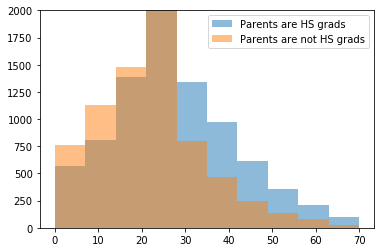

In [20]:
# Plotting a histogram to further show the difference in distribution
plt.hist(math_hs_grad, range = (0,70), alpha = 0.5)
plt.hist(math_no_grad, range = (0,70), alpha = 0.5)
plt.legend(['Parents are HS grads','Parents are not HS grads'])
plt.ylim(0,2000)
plt.show()

# Replicating for ELA proficiency scores

In [22]:
ela_hs_grad = ela[ela['Subgroup ID'] == 91].reset_index(drop = True)
ela_no_grad = ela[ela['Subgroup ID'] == 90].reset_index(drop = True)
ela_hs_grad = ela_hs_grad['Percentage Standard Met and Above']
ela_no_grad = ela_no_grad['Percentage Standard Met and Above']

In [23]:
ela_grad_mean = np.mean(ela_hs_grad)
ela_no_grad_mean = np.mean(ela_no_grad)
ela_grad_std = np.std(ela_hs_grad)
ela_no_grad_std = np.std(ela_no_grad)

print(ela_no_grad_mean, ela_grad_mean)

32.11392907358222 39.453991059232656


In [24]:
ela_hs_grad = ela_hs_grad.fillna(ela_grad_mean)
ela_no_grad = ela_no_grad.fillna(ela_no_grad_mean)

In [25]:
tstat, pval = ttest_ind(ela_hs_grad, ela_no_grad)
print(pval)

9.79623767546172e-305


Another low p-value above indicates that similar to math testing, having parents who graduated from high school does correlate to higher proficiency rates on the ELA SBAC tests.

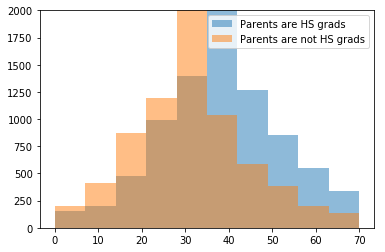

In [26]:
plt.hist(ela_hs_grad, range = (0,70), alpha = 0.5)
plt.hist(ela_no_grad, range = (0,70), alpha = 0.5)
plt.legend(['Parents are HS grads','Parents are not HS grads'])
plt.ylim(0,2000)
plt.show()